# 1 PRELIMINARIES

## Imports

In [1]:
# IMPORTS
import torch
import numpy as np
import os
import pickle
import csv
from argparse import Namespace
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib as mpl
import time

from relevant_optimus_code.configuration_bert import BertConfig
from relevant_optimus_code.configuration_gpt2 import GPT2Config
from relevant_optimus_code.tokenization_bert import BertTokenizer
from relevant_optimus_code.tokenization_gpt2 import GPT2Tokenizer
from relevant_optimus_code.modeling_bert import BertForLatentConnector
from relevant_optimus_code.modeling_gpt2 import GPT2ForLatentConnector
from relevant_optimus_code.run_latent_generation import add_special_tokens_to_decoder, interpolate, latent_code_from_text, text_from_latent_code, top_k_top_p_filtering
from relevant_optimus_code.vae import VAE

## Globals

In [2]:
# GLOBALS
MODEL_CLASSES = {
    'gpt2': (GPT2Config, GPT2ForLatentConnector, GPT2Tokenizer),
    'bert': (BertConfig, BertForLatentConnector, BertTokenizer)}
DEVICE = torch.device("cuda" if torch.cuda.is_available() and not args.no_cuda else "cpu")
print("DEVICE:", DEVICE)
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
ENCODER_MODEL_TYPE = 'bert'
ENCODER_MODEL_NAME = 'bert-base-cased'
DECODER_MODEL_TYPE = 'gpt2'
DECODER_MODEL_NAME = 'gpt2'
MAX_LEN_EX_SPECIAL = 510

SNLI_WIKIPEDIA = 'snli'

GLOBAL_STEP = 31250
LATENT_SIZE = 768
DO_LOWERCASE = False

BATCH_SIZE_ENCODER = 500
BATCH_SIZE_DECODER = 500

DEVICE: cpu


## Paths

In [3]:
# PATHS
PREFIX_PATH = '/Users/claartje/Dropbox (Persoonlijk)/Studie/Master AI/Thesis/code-thesis/Experimentation/Optimus/'
SNLI_MODEL_BASE_PATH = 'output/LM/Snli/768/philly_vae_snli_b{}_d5_r00.5_ra0.25_length_weighted/'
WIKIPEDIA_MODEL_BASE_PATH = 'output/pretrain/philly_rr3_vc4_g8_base_vae_wikipedia_pretraining_beta_schedule_beta{}_d1.0_ro0.5_ra0.25_32_v2/'

DATA_DIR = 'claartje/data/'
DATA_FILES = {'train':'train.txt', 'valid':'valid.txt', 'test':'test.txt'}

def get_model_paths(snli_wikipedia, beta):
    assert snli_wikipedia in ['snli', 'wikipedia']
    if snli_wikipedia == 'snli':
        assert beta in [0.0, 0.5, 1.0]
        global_step = 31250
        cp_dir_path = SNLI_MODEL_BASE_PATH.format(beta)
    elif snli_wikipedia == 'wikipedia':
        assert beta in [0.0, 0.5]
        global_step = 508523
        cp_dir_path = WIKIPEDIA_MODEL_BASE_PATH.format(beta, global_step)
    encoder_path = PREFIX_PATH + cp_dir_path + 'checkpoint-{}/'.format(global_step) + \
                   'checkpoint-encoder-{}'.format(global_step)
    decoder_path = PREFIX_PATH + cp_dir_path + 'checkpoint-{}/'.format(global_step) + \
                   'checkpoint-decoder-{}'.format(global_step)
    full_model_path = PREFIX_PATH + cp_dir_path + 'checkpoint-{}/'.format(global_step) + \
                      'checkpoint-full-{}'.format(global_step)
    return encoder_path, decoder_path, full_model_path

MODEL_PATHS = {}
for snli_wikipedia in ['snli', 'wikipedia']:
    for beta in [0.0, 0.5, 1.0]:
        if (snli_wikipedia == 'wikipedia') and (beta == 1.0):
            continue
        if snli_wikipedia not in MODEL_PATHS:
            MODEL_PATHS[snli_wikipedia] = {}
        enc, dec, full = get_model_paths(snli_wikipedia, beta)
        MODEL_PATHS[snli_wikipedia][beta] = {'encoder_path':enc, 'decoder_path':dec, 'full_path':full}

# 2 INITIALISATION

## Encoder Model (BERT)

## Functions to initialise models

In [4]:
def get_model_tokenizer_encoder(path):
    # Load a trained Encoder model and vocabulary that you have fine-tuned
    encoder_config_class, encoder_model_class, encoder_tokenizer_class = MODEL_CLASSES[ENCODER_MODEL_TYPE]
    model_encoder = encoder_model_class.from_pretrained(path, latent_size=LATENT_SIZE)
    tokenizer_encoder = encoder_tokenizer_class.from_pretrained(ENCODER_MODEL_NAME, do_lower_case=DO_LOWERCASE)
    return model_encoder, tokenizer_encoder

def get_model_tokenizer_decoder(path):
    # Load a trained Decoder model and vocabulary that you have fine-tuned
    decoder_config_class, decoder_model_class, decoder_tokenizer_class = MODEL_CLASSES[DECODER_MODEL_TYPE]
    model_decoder = decoder_model_class.from_pretrained(path, latent_size=LATENT_SIZE)
    tokenizer_decoder = decoder_tokenizer_class.from_pretrained(DECODER_MODEL_NAME, do_lower_case=DO_LOWERCASE)
    model_decoder, tokenizer_decoder = add_special_tokens_to_decoder(model_decoder, tokenizer_decoder)
    return model_decoder, tokenizer_decoder

def get_model_vae(path, model_encoder, model_decoder, tokenizer_encoder, tokenizer_decode):
    checkpoint_full = torch.load(os.path.join(path, 'training.bin'),
                                 map_location=torch.device(DEVICE))
    args = {'latent_size':LATENT_SIZE, 'device':DEVICE}
    model_vae = VAE(model_encoder, model_decoder, tokenizer_encoder, tokenizer_decoder, Namespace(**args))
    model_vae.load_state_dict(checkpoint_full['model_state_dict'])
    model_vae.eval()
    return model_vae

## Init models for different beta values: 0.0, 0.5 and 1.0

In [40]:
decoder_models = {'snli':{}, 'wikipedia':{}}
encoder_models = {'snli':{}, 'wikipedia':{}}
vae_models = {'snli':{}, 'wikipedia':{}}

for snli_wikipedia in ['wikipedia', 'snli']:
    for beta in [0.0, 0.5, 1.0]:
        paths = MODEL_PATHS[snli_wikipedia][beta]

        model_encoder, tokenizer_encoder = get_model_tokenizer_encoder(paths['encoder_path'])
        model_decoder, tokenizer_decoder = get_model_tokenizer_decoder(paths['decoder_path'])

        decoder_models[snli_wikipedia][beta] = model_decoder
        encoder_models[snli_wikipedia][beta] = model_encoder

        vae_models[snli_wikipedia][beta] = get_model_vae(paths['full_path'], model_encoder, model_decoder, 
                                              tokenizer_encoder, tokenizer_decoder)

CONFIG: {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "output_attentions": false,
  "output_hidden_states": false,
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 2,
  "vocab_size": 28996
}



RuntimeError: Error(s) in loading state_dict for BertForLatentConnector:
	size mismatch for linear.weight: copying a param with shape torch.Size([64, 768]) from checkpoint, the shape in current model is torch.Size([1536, 768]).

## Number of parameters VAE models

In [6]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

standard_bert = torch.hub.load('huggingface/pytorch-transformers', 'model', 'bert-base-cased')
standard_gpt2 = torch.hub.load('huggingface/pytorch-transformers', 'model', 'gpt2')

print("Number of parameters in the full VAE:\t\t\t", get_n_params(vae_models['snli'][1.0]))
print("Number of parameters in standard BERT + GPT2:\t\t", get_n_params(standard_gpt2) +  get_n_params(standard_bert))

print("\nNumber of parameters in the decoder (GPT2):\t\t", get_n_params(decoder_models['snli'][1.0]))
print("Number of parameters in a standard decoder (GPT2):\t", get_n_params(standard_gpt2))
print("\nNumber of parameters in the encoder (BERT):\t\t", get_n_params(encoder_models['snli'][1.0]))
print("Number of parameters in a standard encoder (BERT):\t", get_n_params(standard_bert))

del standard_bert
del standard_gpt2

Using cache found in /Users/claartje/.cache/torch/hub/huggingface_pytorch-transformers_master
Using cache found in /Users/claartje/.cache/torch/hub/huggingface_pytorch-transformers_master
Some weights of GPT2Model were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.attn.masked_bias', 'h.1.attn.masked_bias', 'h.2.attn.masked_bias', 'h.3.attn.masked_bias', 'h.4.attn.masked_bias', 'h.5.attn.masked_bias', 'h.6.attn.masked_bias', 'h.7.attn.masked_bias', 'h.8.attn.masked_bias', 'h.9.attn.masked_bias', 'h.10.attn.masked_bias', 'h.11.attn.masked_bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Number of parameters in the full VAE:			 241599744
Number of parameters in standard BERT + GPT2:		 232750080

Number of parameters in the decoder (GPT2):		 132109824
Number of parameters in a standard decoder (GPT2):	 124439808

Number of parameters in the encoder (BERT):		 109489920
Number of parameters in a standard encoder (BERT):	 108310272


## Interpolate with different beta value models

In [7]:
# def interpolate_different_beta(source_sentence, target_sentence, 
#                                vae_models, tokenizer_encoder, tokenizer_decoder,
#                                num_interpolation_steps=9, temperature=1.0, top_k=0, top_p=0.0):
#     for beta in [0.0, 0.5, 1.0]:
#         print('*' * 30)
#         print("Interpolation for BETA: {}".format(beta))
#         print('-')
#         result = interpolate(vae_models[beta], tokenizer_encoder, tokenizer_decoder, 
#                              source_sentence, target_sentence, DEVICE, 
#                              num_interpolation_steps, top_k, top_p, temperature)
#         print()

In [8]:
# sentence_pairs = [["I am very happy", "He is terribly sad"], ["The man walks up the stairs to the woman", "Three women greet a man that walks on the street"]]

# for p in sentence_pairs:
#     print(p[0], '-->', p[1])
#     interpolate_different_beta(p[0], p[1], vae_models, tokenizer_encoder, tokenizer_decoder)

## Auto encode some samples

In [9]:
# def reconstruct_text(input_text, tokenizer_encoder, tokenizer_decoder, vae_models, beta_name, verbose=False):
#     s = time.time()

#     words_random_text = input_text.split(' ')

#     latent_z, _ = latent_code_from_text(" ".join(words_random_text[:318]), 
#                                         tokenizer_encoder, vae_models[beta_name], DEVICE)
#     reconstructed_text = text_from_latent_code(latent_z, vae_models[beta_name], 
#                                                DEVICE, 0, 1.0, 1.0, tokenizer_decoder)
#     if verbose:
#         print("Input text:\n\n", input_text)
#         print("\n\nLength of the text:", len(words_random_text))
#         print("\n\nReconstruction of the text:\n\n", reconstructed_text)
#         print("\nTook {:.2f} seconds to reconstruct the input.".format(time.time() - s))
#     return latent_z, reconstructed_text

## Longer text (325 words, 510 tokens)

In [10]:
# random_text = '''The epic, traditionally ascribed to the Maharishi Valmiki, narrates the life of Rama, prince of the legendary kingdom of Kosala. The story follows his fourteen-year exile to the forest urged by his father King Dasharatha, on the request of Rama's stepmother Kaikeyi; his travels across forests in India with his wife Sita and brother Lakshmana, the kidnapping of Sita by Ravana --the evil king of Lanka, that resulted in war (against evil); and Rama's eventual return to Ayodhya to be crowned king amidst jubilation and celebration. This is the culmination point of the epic. It is considered a sacred book, and is read by millions of people every year.
# There have been many attempts to unravel the epic's historical growth and compositional layers; various recent scholars' estimates for the earliest stage of the text range from the 7th to 4th centuries BCE,[5] with later stages extending up to the 3rd century CE.[6]
# The Ramayana is one of the largest ancient epics in world literature. It consists of nearly 24,000 verses (mostly set in the Shloka/Anustubh meter), divided into five kāṇḍas: the ayodhyakāṇḍa, the araṇyakāṇḍa, the kiṣkindakāṇḍa, the sundarākāṇḍa, and the laṅkākāṇḍa. and about 500 sargas (chapters).The uttarākāṇḍa,the bālakāṇḍa, although frequently counted among the main ones, is not a part of the original epic. Though Balakanda sometimes considered in the main epic, but according to many, Uttara Kanda is a later interpolation and thus it's not attributed to the work of Maharshi Valmiki.[7] In Hindu tradition, the Ramayana is considered to be the Adi-kavya (first poem). It depicts the duties of relationships, portraying ideal characters like the ideal father, the ideal servant, the ideal brother, the ideal husband and the ideal king. The Ramayana was an important influence on later Sanskrit poetry and Hindu life and culture. Its most important moral influence was the importance of virtue, in the life of a citizen and in the ideals of the formation of a state or of a functioning society.'''

# _, _ = reconstruct_text(random_text, tokenizer_encoder, tokenizer_decoder, vae_models, "B1.0", verbose=True)

In [11]:
# random_text_2 = '''We investigate whether the considered unsupervised disentanglement approaches are effective at enforcing a factorizing and thus uncorrelated aggregated posterior. For each trained model, we sample 10 000 images and compute a sample from the corresponding approximate posterior. We then fit a multivariate Gaussian distribution over these 10 000 samples by computing the empirical mean and covariance matrix. Finally, we compute the total correlation of the fitted Gaussian and report the median value for each data set, method and hyperparameter value.'''

# _, _ = reconstruct_text(random_text_2, tokenizer_encoder, tokenizer_decoder, vae_models, "B1.0", verbose=True)

In [12]:
# random_text_3 = '''We investigate whether the considered unsupervised disentanglement approaches are effective at enforcing a factorizing and thus uncorrelated aggregated posterior .'''

# _, _ = reconstruct_text(random_text_3, tokenizer_encoder, tokenizer_decoder, vae_models, "B1.0", verbose=True)

In [13]:
# random_text_4 = '''This is an apple .'''

# _, _ = reconstruct_text(random_text_4, tokenizer_encoder, tokenizer_decoder, vae_models, "B0.0", verbose=True);print('-'*50)
# _, _ = reconstruct_text(random_text_4, tokenizer_encoder, tokenizer_decoder, vae_models, "B0.5", verbose=True);print('-'*50)
# _, _ = reconstruct_text(random_text_4, tokenizer_encoder, tokenizer_decoder, vae_models, "B1.0", verbose=True)

## Encode a set of sentences

In [14]:
import torch.nn.functional as F

def sentence_from_tok_ids(tok_ids_tensor):
    text = tokenizer_decoder.decode(tok_ids_tensor.tolist(), clean_up_tokenization_spaces=True)
    if '<EOS>' in text:
        text = text.split('<EOS>')[0][1:] # cut-off <BOS> and <EOS>
    else:
        text = text.split()[1:] # cut-off <BOS>
    text = ' '.join(text)
    return text

def text_from_latent_code_batch_autoregressive(latents, tokenizer_decoder, model_vae, labels, 
                                               top_p=0.0, top_k=0, temperature=1.0, 
                                               batch_size=300, max_sentence_length=4):
    
    N_batches = int(np.ceil(len(sentences) / batch_size))
    
    decoded = []
 
    for batch_i, batch_latents in enumerate(torch.chunk(latents, N_batches, dim=0)):
        print("DECODE - Batch {:03d}".format(batch_i))
        
        # Start with BOS token
        generated_so_far = torch.tensor(tokenizer_decoder.added_tokens_encoder['<BOS>'], 
                                        dtype=torch.long, device=DEVICE)
        # Make a batch of BOS tokens
        generated_so_far = generated_so_far.unsqueeze(0).repeat(batch_latents.shape[0], 1)
        
        # Generate for the whole batch token per token (autoregressively)
        for i in range(max_sentence_length):
            print('{:03d}'.format(i), end='\r')
            
            with torch.no_grad():
                # Outputs is a tuple (hidden, present)
                loss, (hidden_states, _) = model_vae.decoder(generated_so_far, 
                                                             past=batch_latents, 
                                                             labels=labels[:, i].unsqueeze(1))

                # hidden_states is of dim B x N input_tokens x vocab size
                # we want the output for the last hidden state
                next_token_logits = hidden_states[:, -1, :]

                # No top_k, top_p filtering, 
                # just apply softmax and sample woth that distribution
                next_token_probs = F.softmax(next_token_logits, dim=1)
                next_token = torch.multinomial(next_token_probs, num_samples=1)

                # The generated output can be concatted to the previous ouput
                generated_so_far = torch.cat((generated_so_far, next_token), dim=1)
        
         # Add decoded batch to the outputted batches so fat
        decoded.append(generated_so_far)
    
    # Concat all batches along batch dimension (0)
    decoded = torch.cat(decoded)
    
    return decoded

# TO DO:
def text_from_latent_code_batch_teacher_force(latents, tokenizer_decoder, model_vae, labels, 
                                               top_p=0.0, top_k=0, temperature=1.0, 
                                               batch_size=300, max_sentence_length=4):
    
    N_batches = int(np.ceil(len(sentences) / batch_size))
    
    decoded = []
 
    for batch_i, batch_latents in enumerate(torch.chunk(latents, N_batches, dim=0)):
        print("DECODE - Batch {:03d}".format(batch_i))
        
        # Start with BOS token
        generated_so_far = torch.tensor(tokenizer_decoder.added_tokens_encoder['<BOS>'], 
                                        dtype=torch.long, device=DEVICE)
        # Make a batch of BOS tokens
        generated_so_far = generated_so_far.unsqueeze(0).repeat(batch_latents.shape[0], 1)
        
        # Generate for the whole batch token per token (autoregressively)
        for i in range(max_sentence_length):
            print('{:03d}'.format(i), end='\r')
            
            with torch.no_grad():
                # Outputs is a tuple (hidden, present)
                loss, (hidden_states, _) = model_vae.decoder(generated_so_far, 
                                                             past=batch_latents, 
                                                             labels=labels[:, i].unsqueeze(1))

                # hidden_states is of dim B x N input_tokens x vocab size
                # we want the output for the last hidden state
                next_token_logits = hidden_states[:, -1, :]

                # No top_k, top_p filtering, 
                # just apply softmax and sample woth that distribution
                next_token_probs = F.softmax(next_token_logits, dim=1)
                next_token = torch.multinomial(next_token_probs, num_samples=1)

                # The generated output can be concatted to the previous ouput
                generated_so_far = torch.cat((generated_so_far, next_token), dim=1)
        
         # Add decoded batch to the outputted batches so fat
        decoded.append(generated_so_far)
    
    # Concat all batches along batch dimension (0)
    decoded = torch.cat(decoded)
    
    return decoded

def tokenize_pad_batch(sentences):
    tokenized_sentences = []
    max_len = 0
    
    for i, s in enumerate(sentences):
        tokenized1 =  [101] + tokenizer_encoder.encode(s) + [102]
        if len(tokenized1) > max_len:
            max_len = len(tokenized1)
        tokenized_sentences.append(tokenized1)

    padded_tokenized_sentences = []
    for ts in tokenized_sentences:
        padding = [tokenizer_encoder.vocab['[PAD]']] * (max_len - len(ts))
        padded_tokenized_sentences.append(ts + padding)

    return torch.tensor(padded_tokenized_sentences), tokenized_sentences, max_len

def latent_code_from_text_batch(pad_tok_sentences, tokenizer_encoder, model_vae, batch_size=500):
    N_batches = np.ceil(pad_tok_sentences.shape[0] / batch_size)
    print("{} sentences in total, with max batch size of {} gives {} batches".format(
        len(sentences), batch_size, N_batches))
    
    latents = []
    for batch_i, batch in enumerate(torch.chunk(pad_tok_sentences, int(N_batches), dim=0)):
        print("ENCODE - Batch {:03d}".format(batch_i), end='\r')
        
        coded1 = torch.Tensor.long(batch)
        with torch.no_grad():
            x0 = coded1
            x0 = x0.to(DEVICE)
            _, pooled_hidden_fea = model_vae.encoder(x0, attention_mask=(x0 > 0).float())  #
            mean, logvar = model_vae.encoder.linear(pooled_hidden_fea).chunk(2, -1)
            latent_z = mean.squeeze(1)
            latents.append(latent_z)
    
    return torch.cat(latents)

## Load input sequences & tokenise

In [24]:
max_N_sentences = False
N_sentences = 200
sentences_txt_file = 'sample_text.txt'

sentences = []
with open(sentences_txt_file, 'r') as fd:
    reader = csv.reader(fd, delimiter='\t')
    for i, row in enumerate(reader):
        sentences.append(row[1])
        sentences.append(row[2])
        if max_N_sentences:
            if (len(sentences)>= N_sentences):
                break

# print("N sentences before dropping longer than 20 tokens:", len(sentences))
# sentences = [s for s in sentences if len(s.split(' ')) < 20]   
# print("N sentences after dropping:", len(sentences))
# padded_tokenised_sentences, tokenised_sentences, max_len_sentences = tokenize_pad_batch(sentences)
# print("Maximum sentence length (after tokenisation):", max_len_sentences)
# print("Padded tokenised sentences block shape:", padded_tokenised_sentences.shape)

# lengths_words = [len(s.split(" ")) for s in sentences]
# length_toks = [len(t) for t in tokenised_sentences]
# plt.hist(lengths_words, bins=20, label='words', alpha=0.5)
# plt.hist(length_toks, bins=20, label='tokenised', alpha=0.5)
# plt.show()

In [25]:
sent_batch = sentences #[:20]
tok_sent_batch_enc = []
tok_sent_batch_dec = []

sent_lens = []
tok_sent_lens_enc = []
tok_sent_lens_dec = []

for i, s in enumerate(sent_batch):
    # Encoder BERT tokenise
    tok_enc =  [101] + tokenizer_encoder.encode(s) + [102] # add beginning of sentence and end of sentence
    tok_sent_lens_enc.append(len(tok_enc))
    tok_sent_batch_enc.append(tok_enc)
    
    # Decoder GPT2 tokenise
    tok_dec =  [50258] + tokenizer_decoder.encode(s) + [50259] # '<BOS>': 50258, '<EOS>': 50259
    tok_sent_lens_dec.append(len(tok_dec))
    tok_sent_batch_dec.append(tok_dec)

pad_tok_sent_enc = []
max_len_enc = max(tok_sent_lens_enc)
for ts in tok_sent_batch_enc:
    padding = [tokenizer_encoder.vocab['[PAD]']] * (max_len_enc - len(ts)) # PAD should be 0
    pad_tok_sent_enc.append(ts + padding)

pad_tok_sent_dec = []
max_len_dec = max(tok_sent_lens_dec)
for ts in tok_sent_batch_dec:
    padding = [tokenizer_decoder.added_tokens_encoder['<PAD>']] * (max_len_dec - len(ts)) # PAD should be 50257
    pad_tok_sent_dec.append(ts + padding)
    
pad_tok_sent_dec = torch.stack([torch.tensor(x) for x in pad_tok_sent_dec])
pad_tok_sent_enc = torch.stack([torch.tensor(x) for x in pad_tok_sent_enc])

pad_tok_sent_dec = pad_tok_sent_dec.to(DEVICE)
pad_tok_sent_enc = pad_tok_sent_enc.to(DEVICE)

print("Padded decoder GPT2 input/laebl sequence batch shape:", pad_tok_sent_dec.shape)
print("Padded encoder BERT input sequence batch shape:", pad_tok_sent_enc.shape)

Padded decoder GPT2 input/laebl sequence batch shape: torch.Size([3136, 91])
Padded encoder BERT input sequence batch shape: torch.Size([3136, 86])


In [26]:
# Input VAE_model, Bert encoded sequence (inputs), GPT2 encoded sequences (labels)

def teacher_force_decode(VAE_model, latent_z, labels_GPT2, train=False):
    with torch.set_grad_enabled(train):
        # Calculate a mask of outputs that should be taken into account (shifted padding)
        reconstruction_mask = (labels_GPT2 != 50257).float() 
        shift_reconstruction_mask = reconstruction_mask[:, 1:].contiguous()

        # Decode
        outputs = VAE_model.decoder(input_ids=labels_GPT2, past=latent_z, labels=labels_GPT2, label_ignore=VAE_model.pad_token_id)
        lm_logits = outputs[1] # element 2 is transformer_outputs[1:], don't need that

        # Align labels and outputs
        shift_labels = labels_GPT2[:, 1:] .contiguous() # Shift labels to left, so that align with outputs
        shift_lm_logits = lm_logits[:, :-1, :].contiguous() # Skip last output, so that aligns with labels

        # Functions
        softmax_fn = torch.nn.Softmax(dim=2)
        ce_fn = torch.nn.CrossEntropyLoss(ignore_index=VAE_model.pad_token_id, reduction='none')

        # Convert output to probability to token id prediction
        probs = softmax_fn(shift_lm_logits)
        pred = torch.argmax(probs, dim=2) # take max over the vocab dimension (2)

        # CE loss expects B x Vocab, so force sequence dim into B dim.
        probs_resize = shift_lm_logits.view(-1, shift_lm_logits.size(-1))
        ce_loss_resize = ce_fn(probs_resize, shift_labels.view(-1))
        ce_loss = torch.sum(ce_loss_resize.view(-1, shift_labels.shape[-1]), -1) # put seq. dim. back

        # Mask predictions
        masked_pred = (pred * shift_reconstruction_mask).int()

        return masked_pred, ce_loss

def autoregressive_decode(VAE_model, latent_z, labels_GPT2, max_sent_len=-1, train=False):
    if (max_sent_len == -1):
        max_sent_len = labels_GPT2.shape[1] - 1 # -1 for BOS token
    
    # Skip beginning of sentence token and respect max length
    shift_labels = labels_GPT2[:, 1:max_sent_len+1].contiguous()
        
    # Functions
    softmax_fn = torch.nn.Softmax(dim=2)
    ce_fn = torch.nn.CrossEntropyLoss(ignore_index=VAE_model.pad_token_id, reduction='none')
    
    with torch.set_grad_enabled(train):
        # Start with BOS token
        generated_so_far = torch.tensor(tokenizer_decoder.added_tokens_encoder['<BOS>'], 
                                        dtype=torch.long, device=DEVICE)
        # Make a batch of BOS tokens
        generated_so_far = generated_so_far.unsqueeze(0).repeat(latent_z.shape[0], 1)

        logits_lm_so_far = []
        
        # Generate for the whole batch token per token (autoregressively)
        for i in range(max_sent_len):
            # Outputs is a tuple (hidden, present)
            outputs = VAE_model.decoder(generated_so_far, past=latent_z)
            logits_lm = outputs[0]

            # logits_lm is of dim B x N input_tokens x vocab size
            # we want the output for the last hidden state
            next_token_logits = logits_lm[:, -1, :]
            
            logits_lm_so_far.append(next_token_logits)

            # No top_k, top_p filtering, 
            # just apply softmax and sample woth that distribution
            next_token_probs = F.softmax(next_token_logits, dim=1)
            next_token = torch.multinomial(next_token_probs, num_samples=1)

            # The generated output can be concatted to the previous ouput
            generated_so_far = torch.cat((generated_so_far, next_token), dim=1)

        logits_sequence = torch.stack(logits_lm_so_far, dim=1)
        
        probs_resize = logits_sequence.view(-1, logits_sequence.size(-1))
        ce_loss_resize = ce_fn(probs_resize, shift_labels.view(-1))
        ce_loss = torch.sum(ce_loss_resize.view(-1, shift_labels.shape[-1]), -1) # put seq. dim. back
        
        return generated_so_far[:, 1:], ce_loss

def encode_reconstruct_auto_and_tf(VAE_model, inputs_BERT, labels_GPT2):
    # Mask tokens that are 0 (PAD in BERT)
    attention_mask = (inputs_BERT > 0).float()

    # ENCODE
    _, pooled_hidden_fea = VAE_model.encoder(inputs_BERT, attention_mask)

    # Connect ENCODE - DECODE
    # Now implemented as taking the mean of the std, logvar output, 
    # but can also use the connect function of the VAE model
    # latent_z, loss_kl = self.connect(pooled_hidden_fea); latent_z = latent_z.squeeze(1)
    mean, _ = VAE_model.encoder.linear(pooled_hidden_fea).chunk(2, -1)
    latent_z = mean.squeeze(1)
    
    # DECODE AUTOREGRESSIVE
    gen_pred_auto, ce_loss_auto = autoregressive_decode(VAE_model, latent_z, labels_GPT2)
        
    # DECODE TEACHER-FORCE    
    masked_pred_tf, ce_loss_tf = teacher_force_decode(VAE_model, latent_z, labels_GPT2)

    return gen_pred_auto, ce_loss_auto, masked_pred_tf, ce_loss_tf

In [38]:
BATCH_SIZE = 20
n_batches = int(np.ceil(pad_tok_sent_enc.shape[0] / BATCH_SIZE))

MAX_BATCHES = 3

MAX_LEN = 10
pad_tok_sent_enc = pad_tok_sent_enc[:, :MAX_LEN]
pad_tok_sent_dec = pad_tok_sent_dec[:, :MAX_LEN]

bert_sequence_batches = pad_tok_sent_enc.chunk(N_BATCHES)
gpt2_sequence_batches = pad_tok_sent_dec.chunk(N_BATCHES)

pred_auto, ce_losses_auto, pred_tf, ce_losses_tf = [], [], [], []

results_all_models = {}

for snli_wiki in ['snli', 'wikipedia']:
    results_all_models[snli_wikipedia] = {}
    
    for beta in [0.0, 0.5, 1.0]:
        
        VAE_model = vae_models[snli_wikipedia][beta]
        
        for batch_i in range(n_batches):
            print("Batch {}".format(batch_i))
            p_au, c_au, p_tf, c_tf = encode_reconstruct_auto_and_tf(VAE_model, 
                                                                    bert_sequence_batches[batch_i], 
                                                                    gpt2_sequence_batches[batch_i])

            pred_auto.append(p_au)
            ce_losses_auto.append(c_au)
            pred_tf.append(p_tf)
            ce_losses_tf.append(c_tf)

            if batch_i == (MAX_BATCHES - 1):
                break
        
        results_all_models[snli_wikipedia][beta] = {'pred_auto_all': torch.cat(pred_auto), 
                                                    'ce_losses_auto_all': torch.cat(ce_losses_auto),
                                                    'pred_tf_all': torch.cat(pred_tf), 
                                                    'ce_losses_tf_all': torch.cat(ce_losses_tf)}

Batch 0


/Users/claartje/Dropbox (Persoonlijk)/Studie/Master AI/Thesis/code-thesis/venv/lib/python3.6/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Batch 1
Batch 2
Batch 0
Batch 1
Batch 2
Batch 0
Batch 1
Batch 2
Batch 0
Batch 1
Batch 2
Batch 0
Batch 1
Batch 2
Batch 0
Batch 1
Batch 2
{'wikipedia': {0.0: {'pred_auto_all': tensor([[10153,  3820,   318,  ...,    82, 19493,   837],
        [  262,   835,   345,  ...,  3734,   764, 50259],
        [  340,  2331,   588,  ...,  1682,  6834,   673],
        ...,
        [  612,   318,   257,  ...,  2968,  1267,   508],
        [ 6159, 17075,  4249,  ..., 50259,   764, 50259],
        [  407,  2162,   340,  ..., 50259,   764, 50259]]), 'ce_losses_auto_all': tensor([ 92.0980,  42.0758, 121.9644, 114.4574,  95.3417, 125.9549,  86.5692,
        103.9254, 125.6309,  70.4003, 117.2258, 113.1011,  77.9768,  74.5840,
        110.8536,  98.5428, 122.6319, 120.5788, 136.0773, 157.8465,  79.5266,
         46.3603,  37.0306, 116.4068,  81.5810, 125.2160, 188.6876, 127.9212,
         95.9578,  66.0164, 110.7125,  80.6243, 103.6087, 107.6161,  52.7533,
         80.0944, 162.0876, 160.6633, 147.7967, 153

In [37]:

print(pred_auto_s.shape, ce_losses_auto_s.shape)

torch.Size([60, 9]) torch.Size([60])


In [ ]:
process_sentences = True            

if process_sentences:
        
    latents = {1.0:[], 0.5:[], 0.0:[]}
    decoded_padded = {1.0:[], 0.5:[], 0.0:[]}
    reconstructed_text = {1.0:[], 0.5:[], 0.0:[]}
    reconstructed_text_lenghts = {1.0:[], 0.5:[], 0.0:[]}

    for beta in [1.0]: #0.0, 0.5, 
        print("*"*100)
        print("Beta: {}".format(beta))
        print("-"*100)

        z = latent_code_from_text_batch(padded_tokenised_sentences, tokenizer_encoder, 
                                        vae_models[beta], batch_size=500)
        latents[beta] = z
                
        dec = text_from_latent_code_batch(z, tokenizer_decoder, vae_models[beta], batch_size=500, 
                                          max_sentence_length=10, labels=padded_tokenised_sentences)
        decoded_padded[beta] = dec
        
        reconstructed_text[beta] = []
        reconstructed_text_lenghts[beta] = []
        
        for s in dec:
            r_t = sentence_from_tok_ids(s)
            reconstructed_text_lenghts[beta].append(len(r_t.split(" ")))
            reconstructed_text[beta].append(r_t)

    with open('outputs/latents.pickle', 'wb') as handle:
        pickle.dump(latents, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open('outputs/reconstructed_text.pickle', 'wb') as handle:
        pickle.dump(reconstructed_text, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open('outputs/reconstructed_text_lenghts.pickle', 'wb') as handle:
        pickle.dump(reconstructed_text_lenghts, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open('outputs/decoded_padded.pickle', 'wb') as handle:
        pickle.dump(decoded_padded, handle, protocol=pickle.HIGHEST_PROTOCOL)

else:
    with open('outputs/latents.pickle', 'rb') as handle:
        latents = pickle.load(handle)
    with open('outputs/reconstructed_text.pickle', 'rb') as handle:
        reconstructed_text = pickle.load(handle)
#     with open('outputs/reconstructed_text_lengths.pickle', 'rb') as handle:
#         reconstructed_text_lengths = pickle.load(handle)
    with open('outputs/decoded_padded.pickle', 'rb') as handle:
        decoded_padded = pickle.load(handle)

In [13]:
# for beta in [0.0, 0.5, 1.0]:
#     x = ["I am very happy", "Three women walk past a man up the stairs", "the man walks up the stairs to the woman"]
#     for s in x:
#         z, _ = latent_code_from_text(s, tokenizer_encoder, vae_models[beta], DEVICE)
#         t = text_from_latent_code(z, vae_models[beta], DEVICE, 0, 1.0, 1.0, tokenizer_decoder)
#         print("Original:", s)
#         print("Reconstructed:", t)
#         print('-'*20)

for i, s in enumerate(sentences):
    print("Original:", s)
    
    for beta in [0.0, 0.5, 1.0]:
        print("Beta: {}".format(beta))
        z, _ = latent_code_from_text(s, tokenizer_encoder, vae_models[beta], DEVICE)
        t = text_from_latent_code(z, vae_models[beta], DEVICE, 0, 1.0, 1.0, tokenizer_decoder)
        r_s = reconstructed_text[beta][i]
        print("\tReconstructed:", t)
        print("\tBatch reconstructed:", r_s)
    print("-"*50)
    if i == 10:
        break

Original: I am very happy
Reconstructed: there is very happy woman
--------------------
Original: Three women walk past a man up the stairs
Reconstructed: three women walk past a man up the stairs
--------------------
Original: the man walks up the stairs to the woman
Reconstructed: the man walks up the stairs to the woman
--------------------
Original: I am very happy
Reconstructed: there is very happy woman
--------------------
Original: Three women walk past a man up the stairs
Reconstructed: three women walk past a man up the stairs
--------------------
Original: the man walks up the stairs to the woman
Reconstructed: the man walks up the stairs to the woman
--------------------
Original: I am very happy
Reconstructed: there is very happy
--------------------
Original: Three women walk past a man up the stairs
Reconstructed: three women walk past a man up the stairs
--------------------
Original: the man walks up the stairs to the woman
Reconstructed: the man walks up the stairs to

In [14]:
import json

fn = '../data/datasets/wikipedia_json_64_filtered/wikipedia.segmented.nltk.split.seq64.0.json'

with open(fn) as json_file:
    data = json.load(json_file)

In [17]:
data[0]

{'bert_token': [101,
  3477,
  15693,
  1181,
  1108,
  1824,
  1118,
  4252,
  118,
  27758,
  1611,
  1105,
  3180,
  13601,
  1197,
  7900,
  5506,
  13737,
  3291,
  7582,
  1179,
  1105,
  6924,
  6277,
  2499,
  2087,
  19514,
  1107,
  1103,
  3450,
  1104,
  1729,
  119,
  102],
 'bert_token_length': 34,
 'gpt2_token': [50258,
  3825,
  327,
  1886,
  373,
  7042,
  416,
  409,
  12,
  32,
  5330,
  290,
  20607,
  333,
  15282,
  32705,
  36547,
  1766,
  268,
  268,
  290,
  34269,
  16902,
  1004,
  891,
  17204,
  287,
  262,
  6076,
  286,
  7358,
  13,
  50259],
 'gpt2_token_length': 33}

In [24]:
beta = 1.0

dec_seq_len = decoded_padded[beta].shape[1] - 1 # - 1 for BOS token
mask = (padded_tokenised_sentences > 0).float()
input_ = padded_tokenised_sentences[:, :10]
output_ = decoded_padded[beta][:, 1:] # skip the beginning of sentence token

torch.Size([200, 11])


In [68]:
s1 = "a football coach putting his arm on one of his player's shoulder."
s2 = "two men in blue standing over the window one of them wearing a pink bodysuit riding the other down the street."

_ = interpolate(vae_models[1.0], tokenizer_encoder, tokenizer_decoder, s1, s2, DEVICE, 10, 0.0, 0.0, 1.0)

1 a football player putting his arm on one of his coach's shoulder.
2 a football player putting his arm on another player's shoulder, the one in uniform.
3 a football player putting his arm over another player's shoulder in the performance.
4 a football player putting his foot on the shoulder of another man's jersey.


KeyboardInterrupt: 

Average percentage of words correct per sentence (+- std): 20.50% +- 26.11


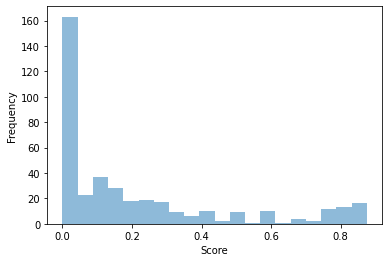

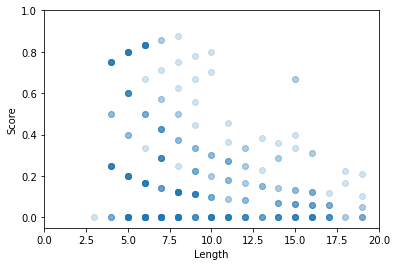

In [52]:
scores = []
scores_corrected = []
lengths = []

for i, (s, rs) in enumerate(zip(sentences, reconstructed_text["B0.0"])):
    
    s_w = s.lower().split(' ')
    rs_w = rs.lower().split(' ')
    
    cor = 0
    for w_i in range(len(s_w)):
        if w_i < len(rs_w):
            if rs_w[w_i] == s_w[w_i]:
                cor += 1
    score = cor / len(s_w)
    scores.append(score)
    lengths.append(len(s_w))
#     scores_corrected.append(score * len(s_w) / 20)

print("Average percentage of words correct per sentence (+- std): {:.2f}% +- {:.2f}".format(np.mean(scores)*100., np.std(scores)*100))
plt.hist(scores, bins=20, alpha=0.5, label='normal')
# plt.legend()
plt.ylabel('Frequency')
plt.xlabel('Score')
plt.show()

plt.scatter(lengths, scores, alpha=0.2)
plt.xlim(0, 20)
plt.ylim(-0.05, 1)
plt.xlabel('Length')
plt.ylabel('Score')
plt.show()

In [55]:
for i, (s, rs) in enumerate(zip(sentences, reconstructed_text["B0.0"])):
    print("Sentence:\t\t", s)
    print("Reconstructed sentence:\t", rs)
    print("-"*20)

Sentence:		 Tasting it is the only reliable way.
Reconstructed sentence:	 it's keeping the shortest of enemies
--------------------
Sentence:		 The way you have it is fine.
Reconstructed sentence:	 the way it's made is
--------------------
Sentence:		 I think it probably depends on your money.
Reconstructed sentence:	 it thinks it might be five
--------------------
Sentence:		 It depends on your country.
Reconstructed sentence:	 it chooses itself on the
--------------------
Sentence:		 You need to read a lot to know what you like and what you don't.
Reconstructed sentence:	 you need to read a book to just like how you like to and
--------------------
Sentence:		 You don't have to know.
Reconstructed sentence:	 nobody can 't
--------------------
Sentence:		 Obviously, the best book for you depends a lot on what you are looking for.
Reconstructed sentence:	 this review of what would be a great book for a few, is only for scraps of
--------------------
Sentence:		 The answer will depend o

Reconstructed sentence:	 nobody can's get
--------------------
Sentence:		 You just have to base your answer on what you do know, which is what you want.
Reconstructed sentence:	 just know where you can give your score, because this is their only way to
--------------------
Sentence:		 I must ask you, are you sure this is what you want to do?
Reconstructed sentence:	 this is ask, why do you want to give anybody's
--------------------
Sentence:		 This problem is one that I commonly come across.
Reconstructed sentence:	 this is one particular problem that has come across the
--------------------
Sentence:		 I had this problem with one cat.
Reconstructed sentence:	 this woman had this problem with
--------------------
Sentence:		 If you are not sure how to do it, don't do it at all.
Reconstructed sentence:	 no one will do this, because they're not sure how to do
--------------------
Sentence:		 If you can't play it or test it out, do not buy.
Reconstructed sentence:	 if anyone tries it, i

In [53]:
len(sentences)

400

## Make t-SNE plots for different Beta

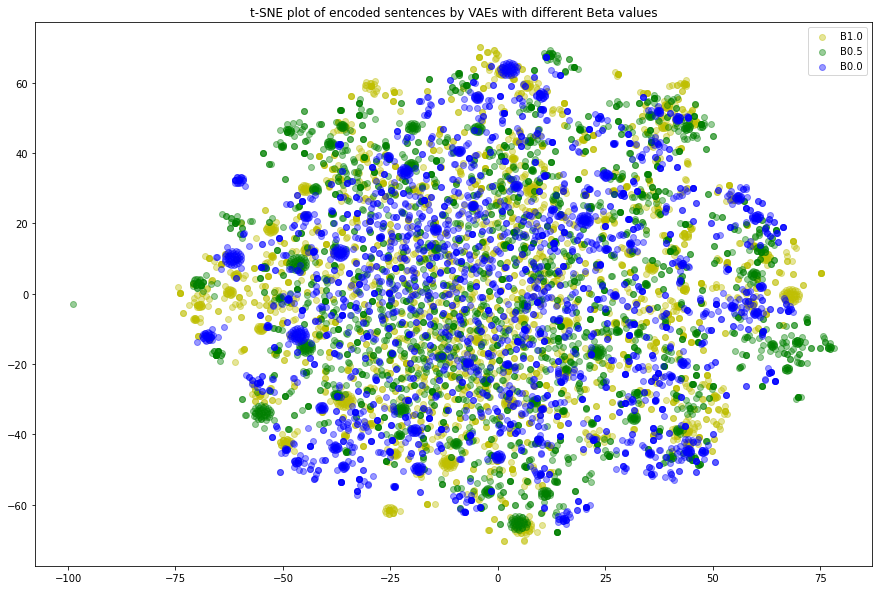

In [60]:
mpl.rcParams['figure.figsize'] = 15, 10

models = {beta_name: TSNE(n_components=2, random_state=0) for beta_name in ["B1.0", "B0.5", "B0.0"]}
data_proj = {beta_name:None for beta_name in ["B1.0", "B0.5", "B0.0"]}
for beta_name, model in models.items():
    data = np.asarray(latents[beta_name])
    data_proj[beta_name] = model.fit_transform(data)
    
colors = ['y', 'g', 'b']
for i, (beta_name, data) in enumerate(data_proj.items()):
    plt.scatter(data[:,0] , data[:,1], color=colors[i], label=beta_name, alpha=0.4)

plt.title("t-SNE plot of encoded sentences by VAEs with different Beta values")
plt.legend()
plt.show()